<a href="https://colab.research.google.com/github/Mustafa-AI7/Mustafa-AI7/blob/main/yearlypltrprojection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd # Import the pandas library with the alias 'pd'


In [21]:
# ======================
# Fetch Historical Data
# ======================
ticker = "PLTR"
data = yf.download(ticker, period="3y", interval="1d")  # 3 years of daily data
closing_prices = data['Close'].values

[*********************100%***********************]  1 of 1 completed


In [22]:
#check data top records

data.head()

Price,Close,High,Low,Open,Volume
Ticker,PLTR,PLTR,PLTR,PLTR,PLTR
Date,,,,,
2022-02-07,12.98,13.600,12.94,13.025,45646100
2022-02-08,13.15,13.189,12.62,12.750,30317100
2022-02-09,13.87,13.890,13.26,13.290,34451900
2022-02-10,13.56,14.165,13.37,13.500,41998200
2022-02-11,13.13,13.920,12.97,13.450,41831600


In [23]:
#check data recent records

data.tail()


Price,Close,High,Low,Open,Volume
Ticker,PLTR,PLTR,PLTR,PLTR,PLTR
Date,,,,,
2025-02-03,83.739998,84.250000,78.470001,80.125000,126592700
2025-02-04,103.830002,106.910004,100.510002,102.800003,230806800
2025-02-05,101.360001,103.570000,99.320000,101.779999,90628300
2025-02-06,111.279999,111.544998,100.260002,101.089996,128217500
2025-02-07,114.389603,116.300003,110.449997,111.660004,109144048


In [24]:
# ======================
# Calculate Parameters
# ======================
# Compute daily log returns (ensure closing_prices is 1D)
returns = np.log(closing_prices[1:]/closing_prices[:-1])

In [25]:
# Annualized parameters (252 trading days)
mu = np.mean(returns) * 252       # Drift (annualized)
sigma = np.std(returns) * np.sqrt(252)  # Volatility (annualized)
S0 = float(closing_prices[-1])    # Explicitly convert to float
days_projection = 252             # Project 1 year forward

print(f"Calibrated Parameters for {ticker}:")
print(f"Initial Price: ${S0:.2f}")  # Now works with float
print(f"Annualized Drift (μ): {mu:.4f}")
print(f"Annualized Volatility (σ): {sigma:.4f}\n")


Calibrated Parameters for PLTR:
Initial Price: $114.39
Annualized Drift (μ): 0.7283
Annualized Volatility (σ): 0.6882



<ipython-input-25-d43b2a1c26de>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S0 = float(closing_prices[-1])    # Explicitly convert to float


In [26]:
# ======================
# Monte Carlo Simulation
# ======================
num_simulations = 1000
dt = 1/252  # Daily time step

In [27]:
# Generate Brownian motion paths
dW = np.random.normal(0, np.sqrt(dt), (num_simulations, days_projection))
W = np.cumsum(dW, axis=1)

In [28]:
# GBM formula
paths = np.zeros((num_simulations, days_projection))
paths[:, 0] = S0

for t in range(1, days_projection):
    paths[:, t] = paths[:, t-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*dW[:, t-1])

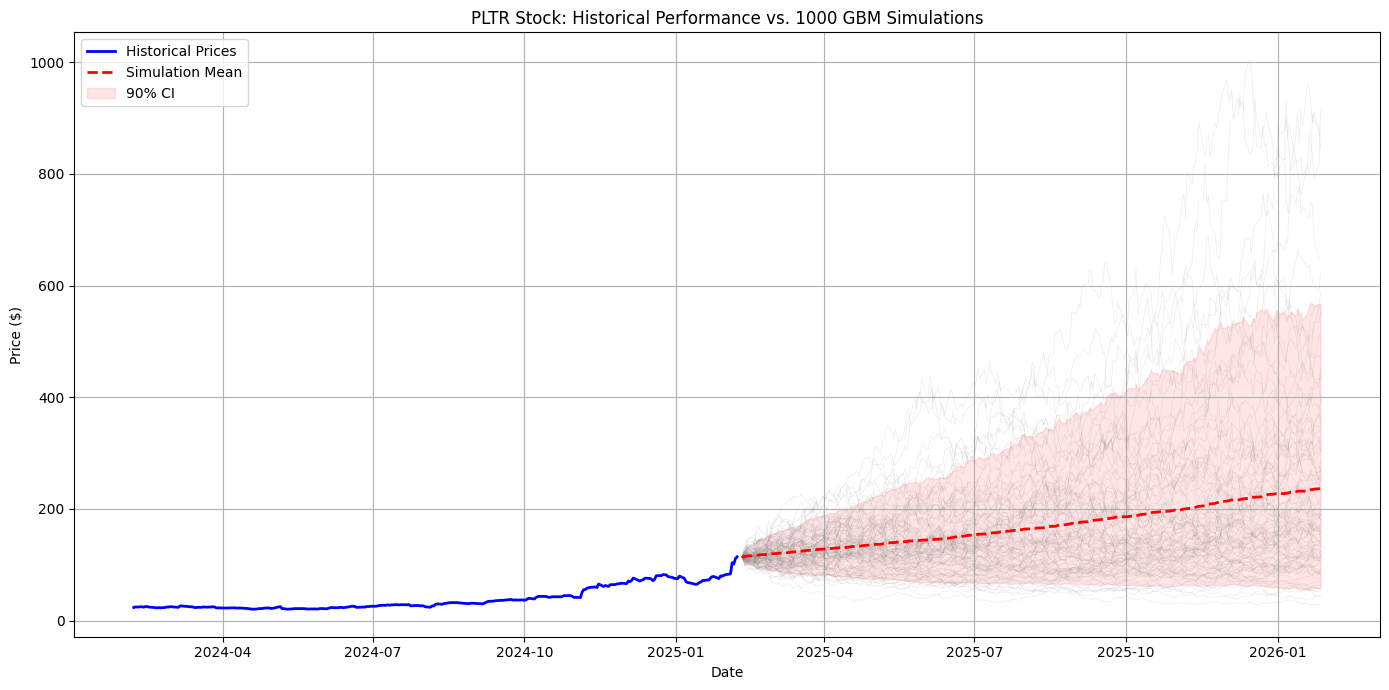

In [29]:
# ======================
# Visualization
# ======================
plt.figure(figsize=(14, 7))

# Plot historical data
historical_dates = data.index[-days_projection:]
plt.plot(historical_dates, closing_prices[-days_projection:], 'b-', lw=2, label='Historical Prices')

# Plot simulations
projection_dates = pd.date_range(start=data.index[-1], periods=days_projection+1, freq='B')[1:]
for i in range(min(num_simulations, 100)):  # Plot first 100 paths for clarity
    plt.plot(projection_dates, paths[i], lw=0.5, alpha=0.15, color='gray')

# Plot mean and percentiles
mean_path = np.mean(paths, axis=0)
plt.plot(projection_dates, mean_path, 'r--', lw=2, label='Simulation Mean')
plt.fill_between(projection_dates,
                 np.percentile(paths, 5, axis=0),
                 np.percentile(paths, 95, axis=0),
                 color='red', alpha=0.1, label='90% CI')

plt.title(f'{ticker} Stock: Historical Performance vs. {num_simulations} GBM Simulations')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:

# ======================
# Final Statistics
# ======================
final_prices = paths[:, -1]
print(f"Projection Statistics ({days_projection} trading days ahead):")
print(f"Mean projection: ${np.mean(final_prices):.2f}")
print(f"Median projection: ${np.median(final_prices):.2f}")
print(f"5th percentile: ${np.percentile(final_prices, 5):.2f}")
print(f"95th percentile: ${np.percentile(final_prices, 95):.2f}")
print(f"Minimum projection: ${np.min(final_prices):.2f}")
print(f"Maximum projection: ${np.max(final_prices):.2f}")

Projection Statistics (252 trading days ahead):
Mean projection: $236.98
Median projection: $182.39
5th percentile: $59.20
95th percentile: $567.22
Minimum projection: $20.55
Maximum projection: $1349.26
